# Подключение git

In [3]:
!rm -rf timeseries-utils
!git clone https://github.com/remix0091/timeseries-utils.git
%cd timeseries-utils

Cloning into 'timeseries-utils'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 162 (delta 109), reused 106 (delta 55), pack-reused 0 (from 0)
Receiving objects: 100% (162/162), 47.53 KiB | 3.39 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/timeseries-utils


# Подключение библиотек

In [4]:
import sys
sys.path.append("/content/timeseries-utils")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mylib.preprocess import prepare_weekly_series, prepare_clean_series, drop_temporal_features, create_features
from mylib.outliers import remove_outliers, plot_outliers, select_outlier_detection_method
from mylib.imputation import impute_series, fill_with_rules, process_all_series
from mylib.evaluation import evaluate_methods_with_mask, evaluate_methods_on_custom_mask, wape, durbin_watson_safe

!pip install catboost --quiet
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


# Загрузка данных

In [5]:
df = pd.read_csv("fact.csv", sep=";", encoding="cp1251")
df.columns = ["week", "series_id", "value"]

# Тест обнаружения выбросов на ряду

[ЛОГ] Ряд: #10
  - Даты: 2020-04-27 — 2023-01-02
  - Преобразовано в NaN по порогу (1e-05): 2
  - Пропущенных недель (NaN): 2
[ЛОГ] Пропусков до удаления выбросов: 2
[ЛОГ] Метод обнаружения выбросов: IsolationForest (fallback)
[ЛОГ] Найдено выбросов: 7
[ЛОГ] Выбросов удалено: 7


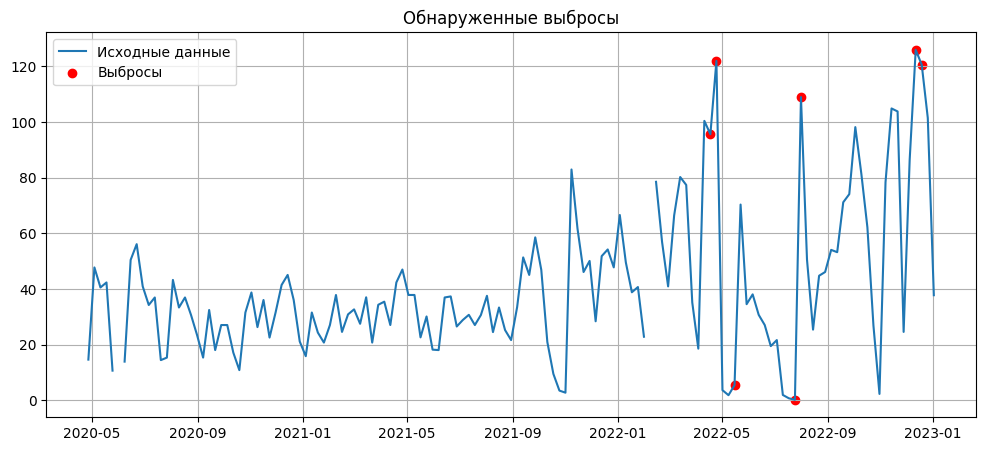

In [6]:
#ручной проверочный сценарий, чтоб отдельно посмотреть, как методы срабатывают на одном ряде
sid="#10" #какой ряд смотрим

# Исходный ряд до удаления выбросов
original_series = prepare_weekly_series(df, sid)

# Очищенный ряд, лог и маска
series_clean, log_meta, outlier_mask = prepare_clean_series(df, sid)

# Визуализация на исходных данных, с той же маской
plot_outliers(original_series, mask=outlier_mask)

# Конфигуратор обработки пропусков

In [14]:
imputation_config = {
    # Ряд #1: использовать автоматическое правило (fill_with_rules)
    "#9": {
        "enable": True,
        "method": "auto"  # выбирается на основе длины пропущенных блоков
    },

    # Ряд #2: заполнение медианой
    "#10": {
        "enable": True,
        "method": "median"
    },

    # Ряд #3: заполнение константой (0)
    "#11": {
        "enable": True,
        "method": "spline",
        "order": 3
    },

    # Ряд #4: пропуски не обрабатываются
    "#12": {
        "enable": True,
        "method": "bfill"
    }
}
#Список возможных параметров для методов
#         "order": 3,                   # если используется spline -> порядок
#         "window": 5,                  # если используется rolling -> окно
#         "fill_value": 0,             # если используется const -> чем заполнять
#         "strategy": "mean",          # для fillna-методов: "mean", "median", "mode"
#         "use_trend": True,           # если метод использует тренд (например, Holt)
#         "limit": 3,                  # макс. длина блока, на который действует метод (в fill_with_rules)
#         "min_valid_block": 3,        # сколько точек подряд нужно, чтобы интерполировать
#         "direction": "forward",      # для ffill / bfill: направление
#         "spline_kind": "cubic"       # если нужно использовать scipy.interpolate

# Основная функция обработки

In [15]:
#идёт по всем series_id, которые есть в imputation_config
# для каждого: формирует ряд, удаляет выбросы, заполняет пропуски, собирает лог, складывает всё в processed["#номер"]
# processed — это словарь, где по каждому ряду лежит:
# {
#     "raw": ...        # до обработки
#     "clean": ...      # после удаления выбросов
#     "filled": ...     # после заполнения пропусков
#     "log": {...}      # словарь с инфой: сколько NaN было, сколько выбросов и т.п.
# }

processed = process_all_series(df, imputation_config, verbose=False, plot=False)

[ЛОГ] Ряд: #9
  - Даты: 2020-04-27 — 2023-01-02
  - Преобразовано в NaN по порогу (1e-05): 1
  - Пропущенных недель (NaN): 1
[ЛОГ] Метод обнаружения выбросов: IsolationForest (fallback)
[ЛОГ] Найдено выбросов: 7
[ЛОГ] Автоматический режим: применяем fill_with_rules(...)
    блок 5:5  len= 1  →  linear
    блок 23:24  len= 2  →  linear
    блок 27:29  len= 3  →  ffill+bfill+spline
    блок 36:36  len= 1  →  linear
    блок 135:135  len= 1  →  linear
[ЛОГ] Ряд: #10
  - Даты: 2020-04-27 — 2023-01-02
  - Преобразовано в NaN по порогу (1e-05): 2
  - Пропущенных недель (NaN): 2
[ЛОГ] Метод обнаружения выбросов: IsolationForest (fallback)
[ЛОГ] Найдено выбросов: 7
[ЛОГ] Метод заполнения: median
  - Пропусков до: 9
  - Пропусков после: 0
[ЛОГ] Ряд: #11
  - Даты: 2020-04-27 — 2023-01-02
  - Преобразовано в NaN по порогу (1e-05): 7
  - Пропущенных недель (NaN): 7
[ЛОГ] Метод обнаружения выбросов: IsolationForest (fallback)
[ЛОГ] Найдено выбросов: 7
[ЛОГ] Метод заполнения: spline
  - Пропусков до

# Визуализация результатов

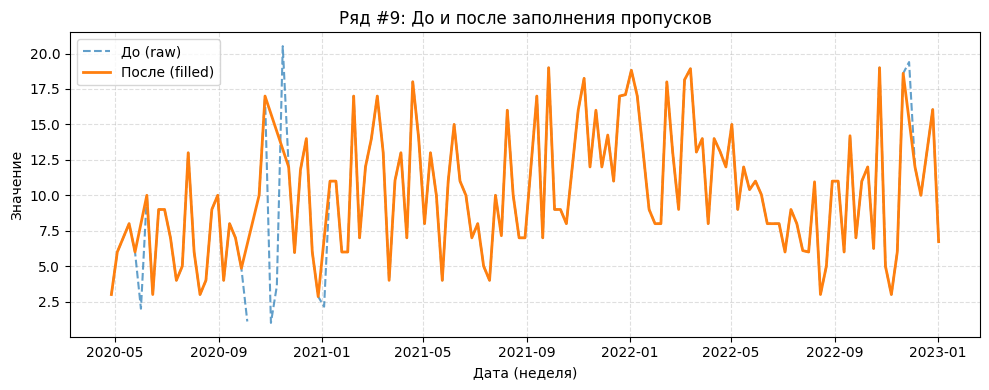

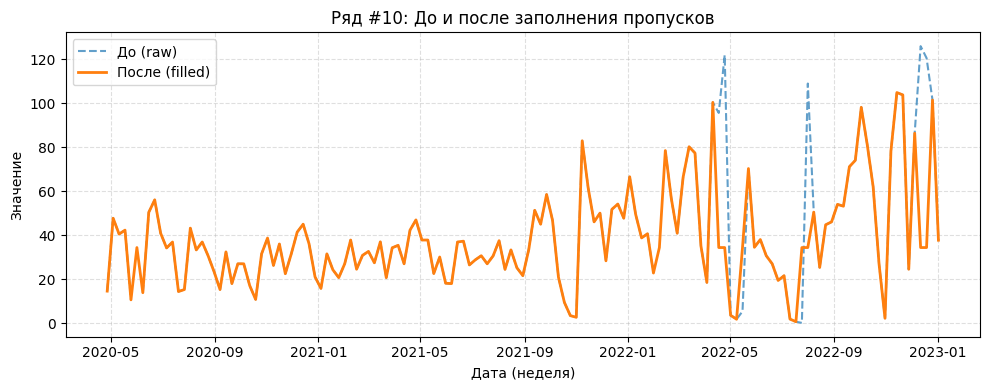

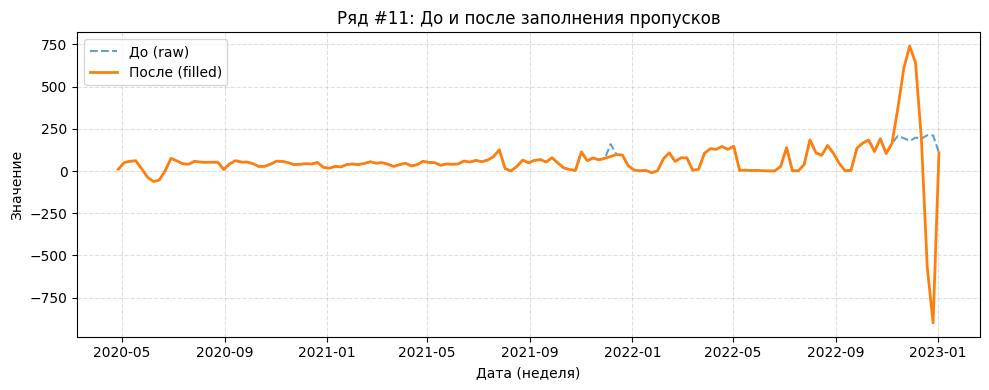

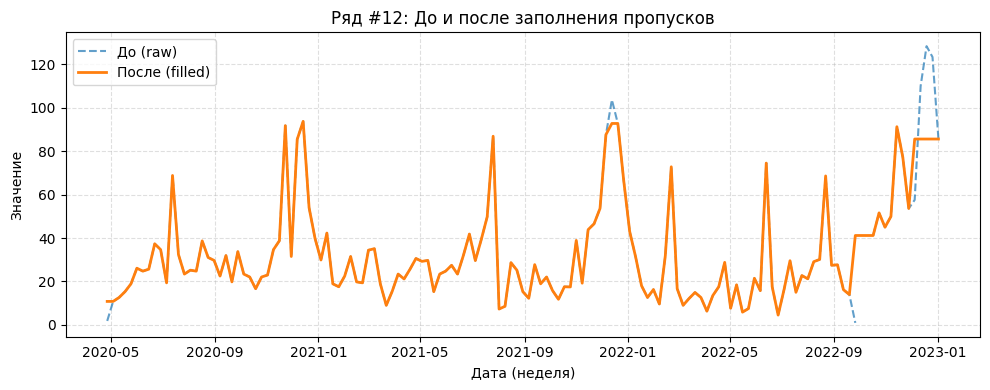

In [16]:
# Визуализация
for sid, series_data in processed.items():
    raw = series_data["raw"]
    filled = series_data["filled"]

    plt.figure(figsize=(10, 4))
    plt.plot(raw, label="До (raw)", linestyle="--", alpha=0.7)
    plt.plot(filled, label="После (filled)", linewidth=2)
    plt.title(f"Ряд {sid}: До и после заполнения пропусков")
    plt.xlabel("Дата (неделя)")
    plt.ylabel("Значение")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Оценка качества восстановления пропусков с заданным шагом



[ЛОГ] Ряд: #1
  - Даты: 2020-04-27 — 2023-01-02
  - Преобразовано в NaN по порогу (1e-05): 6
  - Пропущенных недель (NaN): 6
[ЛОГ] Метод обнаружения выбросов: IsolationForest (fallback)
[ЛОГ] Найдено выбросов: 0
[ЛОГ] Выбросы удалены: 0 точек заменено на NaN
[ЛОГ] Метод заполнения: linear
  - Пропусков до: 33
  - Пропусков после: 0
[ЛОГ] Метод заполнения: mean
  - Пропусков до: 33
  - Пропусков после: 0
[ЛОГ] Метод заполнения: median
  - Пропусков до: 33
  - Пропусков после: 0
[ЛОГ] Метод заполнения: ffill
  - Пропусков до: 33
  - Пропусков после: 3
[ЛОГ] Метод заполнения: bfill
  - Пропусков до: 33
  - Пропусков после: 0
[ЛОГ] Метод заполнения: spline
  - Пропусков до: 33
  - Пропусков после: 0
[ЛОГ] Метод заполнения: rolling
  - Пропусков до: 33
  - Пропусков после: 3


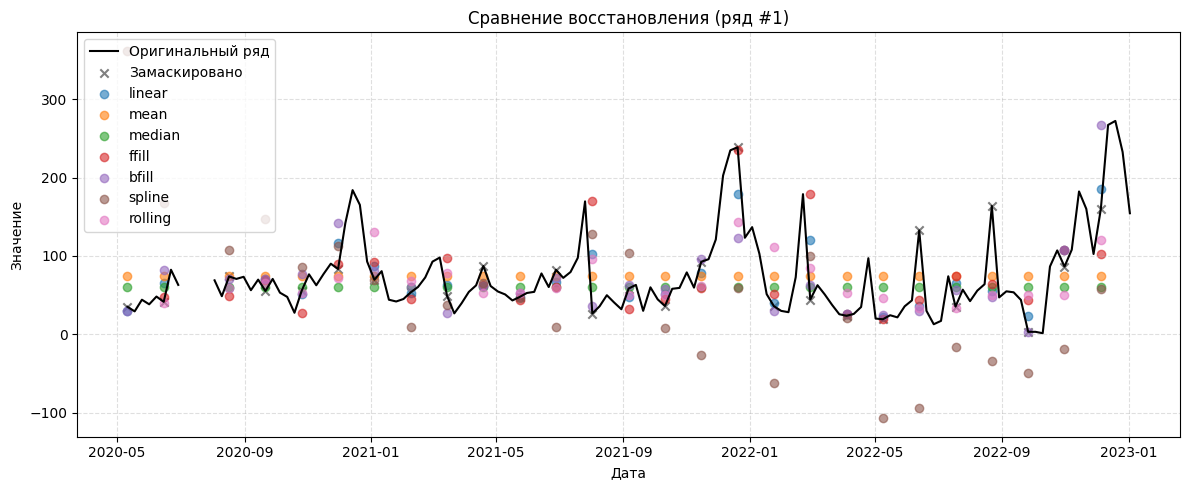

,method,MSE,MAE,MAPE_%,WAPE_%,DW
0,linear,1577.821243,27.116580,65.911013,38.745445,2.438877
1,mean,2601.569739,38.328460,151.485080,54.765506,2.199500
2,median,2684.384835,35.107608,116.877554,50.163403,2.131644
3,ffill,2743.040361,35.658429,113.281575,49.991989,2.498005
4,bfill,2156.425617,28.956525,34.601313,41.374445,1.818120
5,spline,12839.543272,84.427800,216.507280,120.634413,0.722786
6,rolling,2255.283988,35.894722,113.994141,50.323264,2.333980


In [10]:
evaluate_methods_with_mask(df, "#1", step=5, plot=True)

# Оценка качества восстановления пропусков с ручным выкалыванием значений




[ЛОГ] Ряд: #1
  - Даты: 2020-04-27 — 2023-01-02
  - Преобразовано в NaN по порогу (1e-05): 6
  - Пропущенных недель (NaN): 6
[ЛОГ] Метод обнаружения выбросов: IsolationForest (fallback)
[ЛОГ] Найдено выбросов: 0
[ЛОГ] Выбросы удалены: 0 точек заменено на NaN
[ЛОГ] Метод заполнения: spline
  - Пропусков до: 13
  - Пропусков после: 0
  - Параметры: {'order': 3}
[ЛОГ] Метод заполнения: rolling
  - Пропусков до: 13
  - Пропусков после: 2
  - Параметры: {'window': 5}
[ЛОГ] Метод заполнения: linear
  - Пропусков до: 13
  - Пропусков после: 0


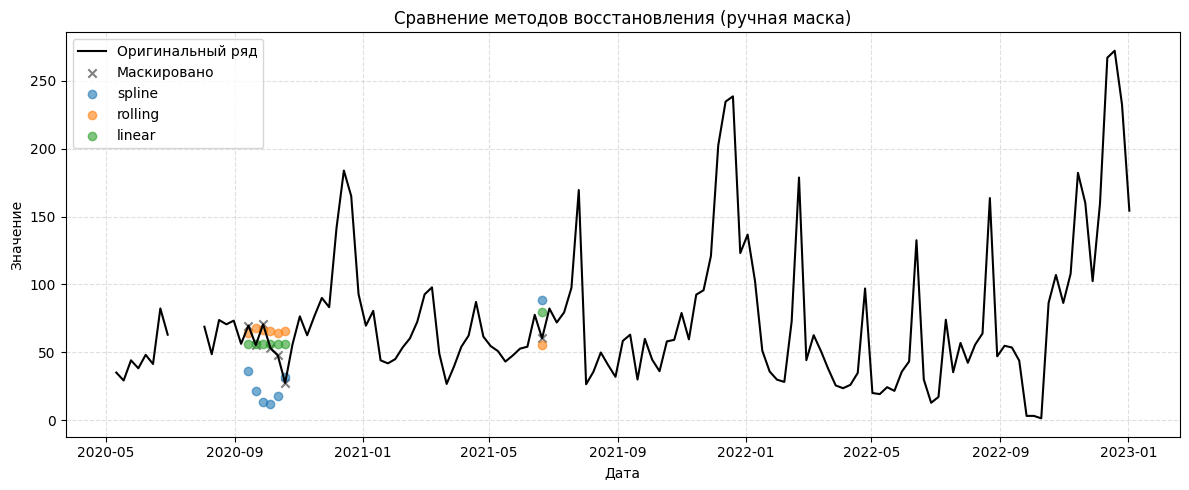

,method,MSE,MAE,MAPE_%,WAPE_%,DW
0,spline,1284.598965,32.710477,56.417322,59.581925,0.303268
1,rolling,302.376348,13.462301,34.555222,24.521495,1.533084
2,linear,238.158367,12.587755,28.613491,22.928516,0.755841


In [11]:
series = remove_outliers(prepare_weekly_series(df, "#1"))
evaluate_methods_on_custom_mask(
    series,
    mask_idx=[(20, 25), series.index[60]],
    methods=["spline", "rolling", "linear"],
    method_params={
        "spline": {"order": 3},
        "rolling": {"window": 5}
    },
    plot=True
)

# Реализация ограничения набора признаков


=== Ряд #9 ===
[ЛОГ] Удалены временные признаки: ['lag_1', 'lag_2', 'lag_3']
[DW]  = 2.524


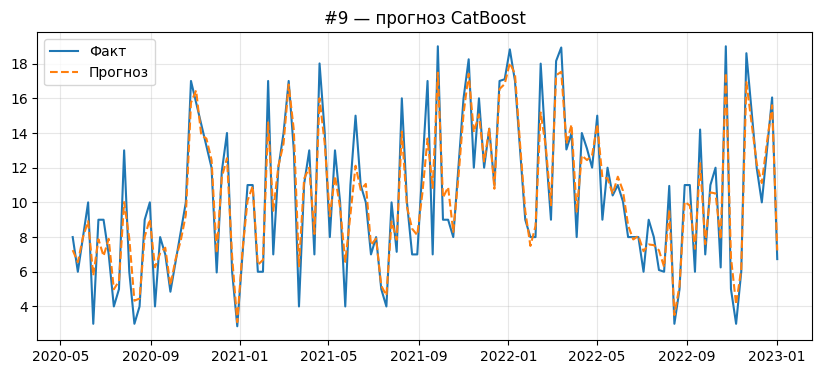

[MLR] DW = 2.181


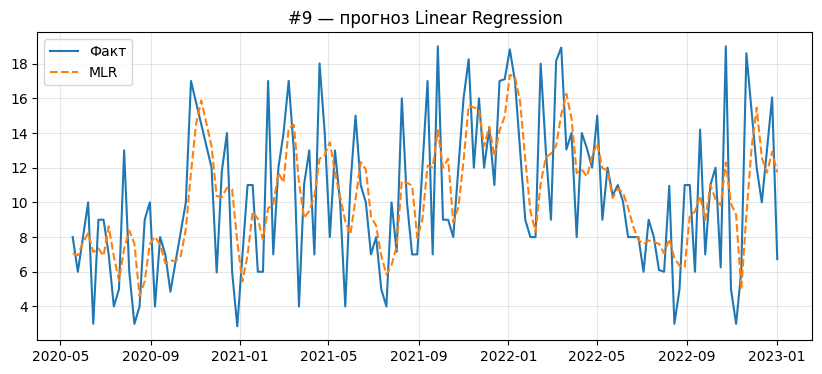


=== Ряд #10 ===
[ЛОГ] Удалены временные признаки: ['lag_1', 'lag_2', 'lag_3']
[DW]  = 2.147


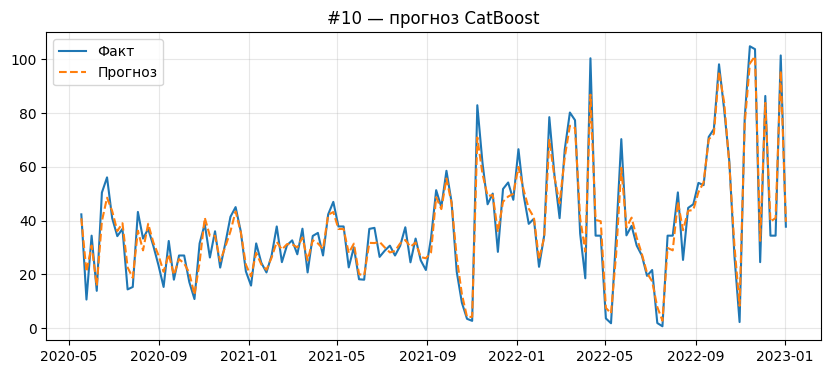

[MLR] DW = 1.933


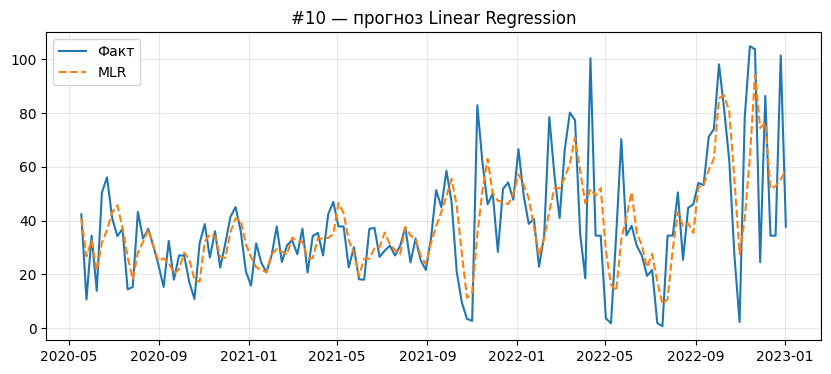


=== Ряд #11 ===
[ЛОГ] Удалены временные признаки: ['lag_1', 'lag_2', 'lag_3']
[DW]  = 1.970


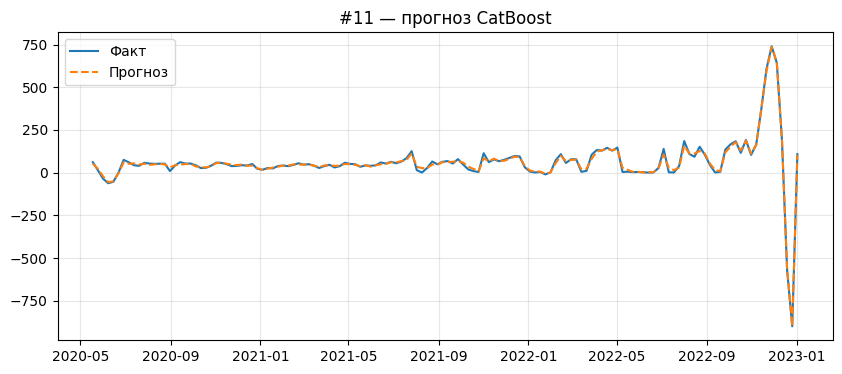

[MLR] DW = 1.132


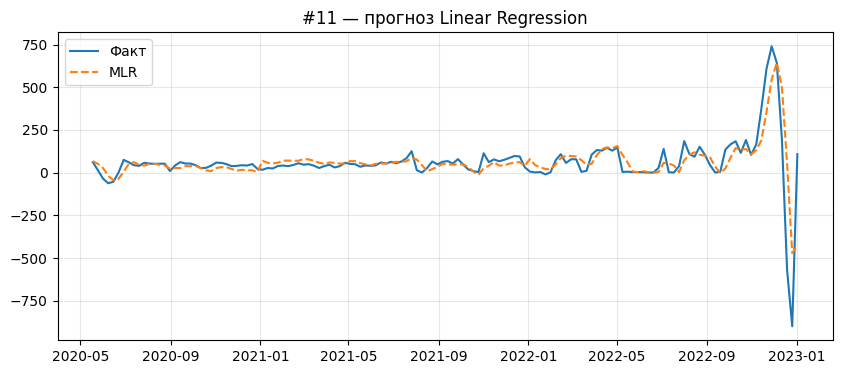


=== Ряд #12 ===
[ЛОГ] Удалены временные признаки: ['lag_1', 'lag_2', 'lag_3']
[DW]  = 2.184


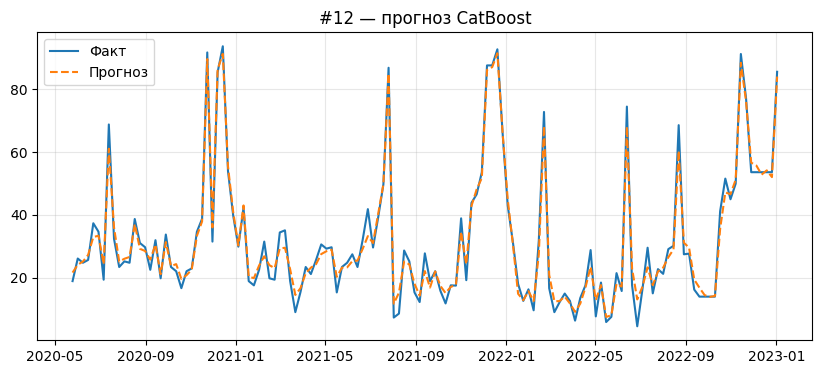

[MLR] DW = 1.924


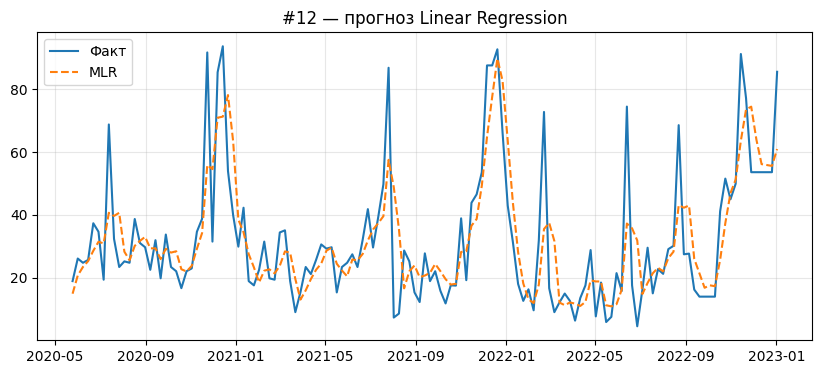

In [12]:
for sid, data in processed.items():
    print(f"\n=== Ряд {sid} ===")

    # 1. Формируем фичи
    df_features = create_features(data["filled"])

    # 2. Удаляем lag-признаки
    df_features = drop_temporal_features(df_features)

    # 3. Обучение
    X = df_features.drop(columns=["y"])
    y = df_features["y"]

#CatBoost
    model = CatBoostRegressor(verbose=0, random_seed=42)
    model.fit(X, y)

    # 4. Прогноз
    y_pred = model.predict(X)

    # 5. Метрики
    dw = durbin_watson_safe(y, y_pred)
    print(f"[DW]  = {dw:.3f}")

    # 6. График
    plt.figure(figsize=(10, 4))
    plt.plot(y.index, y.values, label="Факт", linewidth=1.5)
    plt.plot(y.index, y_pred, label="Прогноз", linestyle="--")
    plt.title(f"{sid} — прогноз CatBoost")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

#MLR
    mlr_model = LinearRegression()
    mlr_model.fit(X, y)
    y_pred_mlr = mlr_model.predict(X)
    dw_mlr = durbin_watson_safe(y, y_pred_mlr)
    print(f"[MLR] DW = {dw_mlr:.3f}")

    plt.figure(figsize=(10, 4))
    plt.plot(y.index, y.values, label="Факт", linewidth=1.5)
    plt.plot(y.index, y_pred_mlr, label="MLR", linestyle="--")
    plt.title(f"{sid} — прогноз Linear Regression")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()